# Rotten Tomatoes Sentiment Analysis 
#### Patrick Huston and James Jang

This notebook aims to explore a revised model for the sentiment analysis Kaggle Rotten Tomatoes competition. Taking what we've learned from our exploration and first iteration model, we hope to improve our techniques and validation of modeling choices in the pursuit of a higher score.

In [1]:
import pandas as pd
import wordcloud
import string
import re
import math
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.grid_search import GridSearchCV
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

from scipy import sparse

%matplotlib inline

/home/patrick/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Data Cleaning Techniques/Creating Features

In natural language processing, the main 'feature' models use is the text itself - and there are several ways to extract numerical values from text. Additionally, there are cleaning steps and techniques that can be taken to improve the representation of the text inputted into the model.

One of the first cleaning techniques that we tried was removing all of the punctuation and turning all of words into lower case. We performed this cleaning technique to normalize our dataset a bit. However, capitalization and punctuation could sometimes affect the sentiment of the sentence so this cleaning technique might not always be the best.

Another cleaning technique that we used was removing stopwords. Stopwords in english are words that are hold no meaning in the overall sentences. Words like the, and, of etc. are common stopwords that does not really contribute to the overall sentiment of the sentence. Note: this step is performed as part of another step we took when using a scikit-learn's `TfidfVectorizer`. See the section titled 'Creating Numerical Features from Text Data' to see this in action.

Next, we implemented some additional cleaning techniques used to further normalize the data - porter stemming and lemmatization. Porter stemming is the process of removing common morphological and inflexional endings from words in English. This is accomplished using simple algorithms that don't have any inherent knowledge of the English language, instead applying a set of rules to break down words and remove endings. Lemmatization, on the other hand, uses an input English dictionary to apply more intelligent breakdown of words based on part of speech. Unfortunately, lemmatization requires that every word be tagged with part of speech, which is an additional data processing step that, in the end, offered no real improvement in accuracy. For this reason, we decided to stick with the simpler algorithm, porter stemming. 

In [2]:
# Load in the dataset
train = pd.read_csv("data/train.tsv", sep= '\t')
test = pd.read_csv("data/test.tsv", sep= '\t')

#### Simple Phrase Cleaning
Let's define our baseline simple phrase cleaning function. It takes in a phrase, splits on spaces, removes punctuation on the outside of words (preserving meaningful punctuation like `didn't` and `should've`, and then joins, lowers, and returns the resulting phrase.

In [3]:
def clean_phrase_simple(phrase):
    # Grab only words and lower them
    clean_str = [word.strip(string.punctuation) for word in phrase.split(" ")]
    return ' '.join(clean_str).lower()

#### Phrase Cleaning with Porter Stemming and Lemmatizing

The following functions offer the same functionality as `clean_phrase_simple`, but with the addition of porter stemming and lemmatizing. 

In [4]:
porter_stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

def clean_phrase_porter(phrase):
    stemmed = [porter_stemmer.stem(word.strip(string.punctuation)) for word in phrase.split(" ")]
    return ' '.join(stemmed).lower()

def clean_phrase_lemmatizer(phrase):
    stemmed = [wordnet_lemmatizer.stem(word.strip(string.punctuation)) for word in phrase.split(" ")]
    return ' '.join(stemmed).lower()

#### Applying Cleaning Functions

While we're at it, let's also define some convenience methods to apply our cleaning functions.

In [5]:
def apply_transform(data):
    data['CleanPhrasePorter'] = data['Phrase'].apply(clean_phrase_porter)
    data['CleanPhraseSimple'] = data['Phrase'].apply(clean_phrase_simple)

In [6]:
apply_transform(train)
apply_transform(test)

### Creating Numerical Features from Text Data

Now that we've explored some different methods of preprocessing the text, it's time to get into the machine learning. This will involve representing our text-based data numerically and then using this representation to fit a model to. 

One such way of representing text as numerical features is TFIDF - term-frequency inverse-document-frequency. Term frequency involves computing the total number of times each given token in a document appears. Inverse document frequency is an additional step that normalizes for the frequency of appearance of each token in the overall corpus. Inverse document frequency diminishes the weight of terms that occur very frequently in the document set and increases the weight of terms that occur rarely. 

To compute the TFIDF for our data, we use scikit-learn's TfidfVectorizer, a convenient tool that takes care of the details. In reality, however, TFIDF is relatively simple to implement.

In [7]:
def vectorize(train, test, column):
    vectorizer = TfidfVectorizer()
    vectorizer.fit(train[column])
    
    X = vectorizer.transform(train[column])
    X_test = vectorizer.transform(test[column])
    
    return X, X_test, vectorizer

In [8]:
X, X_test, vectorizer = vectorize(train, test, 'Phrase')

X_cleaned, X_test_clean, vectorizer_clean = vectorize(train, test, 'CleanPhraseSimple')

#### Further Discussion on Representing Text as Numerical Features

What we've done here is a 'bag or words' approach. This means that we've essentially broken down any contextual meaning of words within the sentence, instead choosing to represent a phrase as an unordered collection of words. Additionally, we are using each single word as a token, which is known as a unigram model. In some situations where there is a sufficiently large dataset, bigrams (tokens of two words), trigrams (tokens of three words), etc. may also be used to take into account the contextual meaning of multiple words together (e.g. 'great movie'). In some cases, it works well to combine a unigram representation with some n-gram representation as well. Based on our research and analysis, however, we believe this dataset (with a mere ~7000 unique sentences, and a relatively small vocabulary of 15,000 words) isn't large enough to have n-grams be effective.

### Creating Models

To facilitate the process of testing a bunch of models, we've made the process easier by defining some convenience methods that iterate over a dictionary of models that we create. Through this process, we'll be able to compare each model's performance against the others, and make an informed decision.

Here are all of the models we'll be trying:

1. Logistic Regression
    - We'll start with a simple multi-class logistic regression model. A common mistake in machine learning, especially in natural language processing, is to ignore the simpler models in lieu of the sexier new techniques - the likes of deep learning and neural networks. If nothing else, this will serve as a good benchmark for the rest of our models.

2. Logistic Regression - Tuned
    - Moving on from the logistic regression benchmark, let's also create a tuned vesion, which defines a list of penalty weights to test from. This will give us a better idea of how much tuning can help.
    
3. Random Forest Model
    - Random forests can be great - it mostly depends on what the data looks like. In this case, we're a little hesitant about its ability to model the data as it seems to be more linear in many aspects than all over the place and random, which a set of decision trees could model more accurately.
    
4. Multinomial Naive Bayes
    - In a lot of text analysis, it is somewhat common practice to start with a Naive Bayes model as a good baseline benchmark. Additionally, it is useful when there are limited resources in terms of CPU and Memory - it can be trained very quickly. 
    
5. Support Vector Machine
    - We also chose to test a linear  and rbf implementation of scikit-learn's Support Vector Machine (SVM). SVM models are generally known to be good choices in cases of very high dimensionality, and the TFIDF vectors we have created fit the bill well.

In [9]:
# Logistic regression
logistic = LogisticRegression(multi_class='multinomial', solver='newton-cg')

# Tuned logistic regression
logisticTune = LogisticRegressionCV(Cs=[math.e**v for v in range(-5,5)],
                                    multi_class='multinomial',
                                    solver='newton-cg')

# Random forest model
random = RandomForestClassifier()

# Multinomail Naive Bayes
multinomial = MultinomialNB()

# Support Vector Machine Linear SVC
SVMLinear = svm.LinearSVC(penalty = 'l2', dual = False, tol = 1e-3)

# Support Vector Machine Linear SVC - tuned
SVMSVC = svm.SVC(tol = 1e-3)

# Compile dictionary of models for later use
models = {'Logistic': logistic, 'TunedLogistic': logisticTune, 
          'RandomForest': random, 'Multinomial' : multinomial, 
          'SVMLinear': SVMLinear, 'SVMSVC': SVMSVC}

models = {'TunedLogistic': logisticTune}

Before we get to the testing, let's define some convenience methods that we can use to break down the tasks involved in getting some validation. 

In [10]:
# Cross-validates model within trainnig set with a split of 'cv' - default value of 3
def cross_validate(model, X, y, cv=3):
    return cross_validation.cross_val_score(model, X, y, cv=cv).mean()
 
# Performs train-test split on data, trains on train, tests on test, returns score
def train_test_splitter(model, X, y, train_size=0.5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
    model.fit(X_train, y_train)
    return X_train, X_test, y_train, y_test, model

# iterates over all different models and print out their results of train_test_splitter
def test_models(models, X, y = train.Sentiment):
    for modelName, model in models.iteritems():
        print modelName
        X_train, X_test, y_train, y_test, model = train_test_splitter(model, X, y, train_size=0.5)
        print model.score(X_test, y_test)
        
# test one specific model with train_test_splitter
def test_model(model, X, y = train.Sentiment):
    return train_test_splitter(model, X, y, train_size=0.5)       

# trains the model on the whole dataset, predicts on the test set and creates a submission file to kaggle
def train_submit(model, X_train, X_test, y_train= train.Sentiment, filename = "submission.csv"):
    print "fitting"
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    output = pd.DataFrame( data={"PhraseId":test["PhraseId"], "Sentiment":prediction} )

    # Use pandas to write the comma-separated output file
    output.to_csv(filename, index=False, quoting=3 )
    print "done"

 ### Testing Models
 
 Now that we have a good sampling of models defined and some good functions ready to do some intelligent testing, let's get right to it! All we have to do at this point is call our `test_models` function, and wait while the results come in.

In [20]:
print "------ No Preprocessing ------"
test_models(models, X)
print "-------- Preprocessed --------"
test_models(models, X_cleaned)

------ No Preprocessing ------
TunedLogistic
0.63906189927
-------- Preprocessed --------
TunedLogistic
0.637459951301


### Tuning Model Parameters

If your goal is to get the best score possible, now is the time to tune. Analyzing the results from our testing above, we can see that the two most promising models are the tuned logistic regression and support vector machine algorithms. Using scikit-learn's GridSearchCV, we can test any set of parameters a model might take in by representing them as a dictionary (see `parameters` dictionary below). Then, GridSearchCV exhaustively tests every combination, and returns the optimal set of parameters. While this approach will get you the 'best' combination, it will take a long time doing so. In situations where more parameters are being tested, other options, like RandomizedSearchCV, may be more appropriate. 

For the purposes of this exploration, we've chosen to show an example of how we might tune one of our chosen models - in this case, the support vector machine. We'll tune two parameters - the kernel and the C value, which represents the penalty weighting for chosen coefficients.

In [ ]:
# Support Vector Machine Linear SVC
svr = svm.SVC()
parameters = {'kernel':('linear', 'rbf'), 'C':[math.e**v for v in range(-5,5)]}

clf = GridSearchCV(svr, parameters)
clf.fit(X_cleaned, train.Sentiment)

### Visualizing Model Behavior

To gain insights into how our model is working, let's try out some visualizations. Because we are using a TFIDF encoding of the data, we can visualize the relative 'importance' of words for predicting each category. For movie reviews with score 0 or 1, we would expect to see a high importance for words like `bad`, `terrible` etc. 

To make these wordclouds, we'll be using the python package `wordcloud`

In [3]:
def make_word_cloud(feature_names, coefficients):
    """ Create a word cloud with the words given by feature_names
        and given coefficients. """
    cloud = wordcloud.WordCloud()
    cloud.generate_from_frequencies(zip(feature_names, coefficients))
    return cloud.to_image()

Each of our models, while offering slightly different accuracies, should produce pretty similar wordclouds. For now, we'll test on a simple untuned Logistic Regression model, which will be good enough for visualization purposes.

In [23]:
# Create model and extract trained coefficients
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, train.Sentiment, train_size=0.5)
model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

#### Analysis of Output

Our expectations are largely met for the wordclouds below. For the negative and positive scores, we see clusters of words that have strong correlation to the score. `Worst` as an indicator of sentiment score 0 makes sense, while `best` makes sense for very positive scores of 4. The interesting behavior here is in the neutral category - we end up with words like `grandson` and `supposed`. It's unclear why these words in specific ended up having correlations to sentiment scores of 2, but it is clear that these words don't inherently have any strong sentiment in the english language.

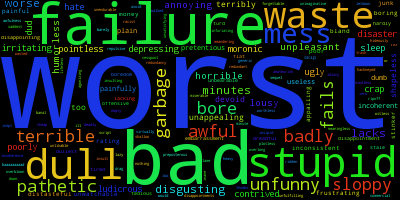

In [18]:
# Word cloud for sentiment value 0 (negative)
make_word_cloud(vectorizer_clean.get_feature_names(), model.coef_[0,:])

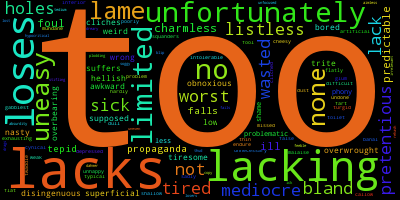

In [19]:
# Word cloud for sentiment value 1 (somewhat negative)
make_word_cloud(vectorizer_clean.get_feature_names(), model.coef_[1,:])

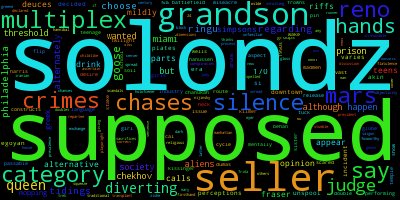

In [20]:
# Word cloud for sentiment value 2 (neutral)
make_word_cloud(vectorizer_clean.get_feature_names(), model.coef_[2,:])

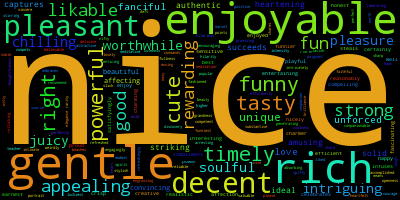

In [21]:
# Word cloud for sentiment value 3 (somewhat positive)
make_word_cloud(vectorizer_clean.get_feature_names(), model.coef_[3,:])

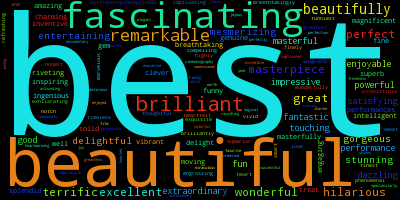

In [22]:
# Word cloud for sentiment value 3 (positive)
make_word_cloud(vectorizer_clean.get_feature_names(), model.coef_[4,:])

### Back to the Exploration

Back in our data exploration, we noticed a strong positive correlation between the length of the phrase and the standard deviation of the sentiment. In other words, a high proportion of short phrases ended up with a neutral sentiment score of 2, while longer phrases were much more all over the place - scoring many more 0s, 1s, 3s, and 4s. For this reason, let's look into whether the addition of the number of words as a feature will add any accuracy to the model. Below, let's define an `add_word_length` function that will add an extra column to the TFIDF feature vector for the model to learn from.

In [16]:
def add_word_length(X, data):
    num_words_feature = np.asarray(map(lambda x: len(x.split()), data.Phrase))
    num_words_feature = num_words_feature[:, np.newaxis]
    return sparse.hstack((X, num_words_feature))

Now, let's put this function to use and do some validation.

In [17]:
X_with_word_length = add_word_length(X, train)
X_test = add_word_length(X_test, test)
# test_models(models, X_with_word_length)

#### Comparing Model Improvement

To test whether a given decision has made an improvement, we'll define a `compare_model_improvement` function here that will help us test two models on a given feature set X.

In [18]:
def compare_model_improvment(model1, model2, X):
    first = test_model(model1, X)
    second = test_model(model2, X)
    print "model 1", first
    print "model 2", second
    print "difference in the score", second - first

In [ ]:
compare_model_improvment(logistic, logisticTune, X)

In [19]:
train_submit(logistic, X_with_word_length, X_test, filename = "submission.csv")

fitting
done


In [21]:
def add_phrase_length(X, data):
    num_words_feature = np.asarray(map(lambda x: len(x), data.Phrase))
    num_words_feature = num_words_feature[:, np.newaxis]
    return sparse.hstack((X, num_words_feature))

In [110]:
X_add_phrase = add_phrase_length(X, train)
X_add_two = add_word_length(X_add_phrase, train)
X_add_two_t = add_word_length(X_add_phrase_t, test)

In [20]:
# print X_add_phrase
# print "-----"
# print X_add_two
# test_models(models, X_add_two_t)

### Accuracy and Precision

We wanted explore how precise and accurate our model was. First thing we explored was classification_report that is included in sklearn.metrics. This gave a quick run down on precision, recall, f1-score. Then we wanted to see how accurately the model distinguishes negative, neutral, and positive.

Next thing we explored was observing the prediction for each Sentiment. (more writing)

We can probably make this in to a function so we can see the results for different models.

In [25]:
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test, model = train_test_splitter(logisticTune, X, train.Sentiment)
y_pred = model.predict(X_test)

target_names = ["Negative", "Somewhat Negative", "Neutral", "Somewhat Positive", "Positive"]
print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

         Negative       0.52      0.25      0.34      3508
Somewhat Negative       0.53      0.41      0.46     13594
          Neutral       0.69      0.85      0.76     39931
Somewhat Positive       0.56      0.48      0.52     16446
         Positive       0.56      0.30      0.39      4551

      avg / total       0.62      0.64      0.62     78030



In [127]:
def transform(y_pred):
    result = []
    for pred in y_pred:
        if pred == 0:
            result.append(1)
        elif pred == 4:
            result.append(3)
        else:
            result.append(pred)
    return result
three_class = transform(y_pred)
three_class_r = transform(y_test)
            
target_names = ["Negative", "Neutral", "Positive"]
print(classification_report(three_class_r, three_class, target_names=target_names))      

             precision    recall  f1-score   support

   Negative       0.72      0.51      0.60     17135
    Neutral       0.69      0.85      0.76     39841
   Positive       0.76      0.61      0.68     21054

avg / total       0.72      0.71      0.70     78030



In [55]:
results = {0: [], 1:[], 2:[], 3:[],4: []}
i = 0
for index, y in y_test.iteritems():
    results[y].append(y_pred[i])
    i +=1
print i
print len(results[0]), len(results[1]), len(results[2]), len(results[3]), len(results[4])


78030
3508 13594 39931 16446 4551


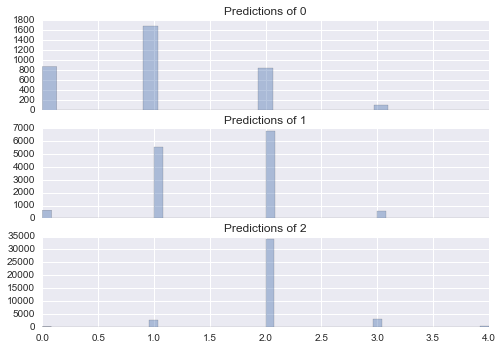

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True)
sns.distplot(results[0],kde=False, ax=ax0);
ax0.set_title('Predictions of 0')
sns.distplot(results[1],kde=False, ax=ax1);
ax1.set_title('Predictions of 1')
sns.distplot(results[2],kde=False, ax=ax2);
ax2.set_title('Predictions of 2')

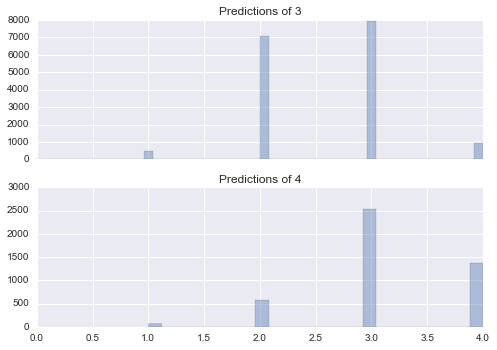

In [74]:
fig, (ax3, ax4) = plt.subplots(nrows=2, sharex=True)
sns.distplot(results[3],kde=False, ax=ax3);
ax3.set_title('Predictions of 3')
sns.distplot(results[4],kde=False, ax=ax4);
ax4.set_title('Predictions of 4')

In [108]:
X_add_phrase_t = add_phrase_length(X_test, test)
train_submit(logisticTune, X_add_phrase, train.Sentiment, X_add_phrase_t)

fitting
done


We decided to play around with the Word2Vec that Paul created so we fed the the matrix that he came up with into our pipeline

In [43]:
import pickle
f = open('rotten_tomatoes_train.pickle')
X_pickle = pickle.load(f)
y_pickle = pickle.load(f)
f.close()

In [45]:
models = {'Logistic': logistic, 'TunedLogistic': logisticTune, 'RandomForest': random, 'SVM': SVM}
test_models(models, X_pickle, y_pickle)

RandomForest
0.56852492631
SVM
0.556068178906
TunedLogistic
0.560771498142
Logistic
0.560105087787


As Paul mentioned the model didn't show much promise. For some reason Multinomial bayes had a problem with the pickled data that was provided so we took it out of the models that we tested.